# Example Jupyter Notebook: An Internal Structure Model for Earth

S.T. Stewart<br>
sts@ucdavis.edu<br>
September 27, 2019

In this notebook, we will practice reading in data, making plots, writing data to a file, and saving plots in different formats. We will use the calculation of Earth's interior structure as our example and compare the calculation to the Preliminary Reference Earth Model (PREM).

## Why use a Jupyter Notebook?

A Jupyter Notebook is a useful format for documenting your work because you can mix text and code cells in a logical order.

This is a 'Markdown' cell, which recognizes HTML and LaTeX formatting commands. This cell has a 2nd-level header format, a bulleted list and latex formatting for the subscripts in the mineral formula.
<ul> 
    <li>Double-clicking on the cell will reveal the markdown code.</li>
    <li>Shift-enter will format the cell into text in your web browser.</li>
    <li>Take a moment to click on the cell and look at the formatting commands.</li>
</ul>

Our model planet will be comprised of two layers: a silicate mantle and iron core. In most numerical simulations of giant impacts, the mantle is modeled using the equation of state (EOS) for forsterite, Mg$_2$SiO$_4$, and the core is modeled using the EOS for pure iron, Fe. Some of the issues that arise from such a simple planet model will be identified in this exercise. 

In [1]:
# This is a code cell
# In code cells, # denote the start of comments


# Record the verions information for these calculation for posterity
import platform
print('python version: ',platform.python_version())
del platform
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version: ', numpy.__version__)
del numpy
import scipy
print('scipy version: ', scipy.__version__)
del scipy


# First we import python libraries and a custom color table
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colormaps as local_cmaps

plt.rcParams["figure.figsize"] = (20,10) # default figure size in inches

python version:  3.7.3
matplotlib version:  3.0.3
numpy version:  1.16.2
scipy version:  1.2.1


In [2]:
# Declare some standard variables
G = 6.67E-11 # Gravitational constant  m3/kg/s2
Mearth = 5.972E24 # Earth's mass kg
Rearth = 6371.E3  # Earth's radius m
Rcmb = 3480000. # CMB radius in m (from PREM)

## First gather the PREM data

PREM is a one-dimensional average structure model for the Earth developed from seismic data. The original reference is:<br>
<b>Dziewonski, A. M., and D. L. Anderson. 1981. "Preliminary reference Earth model." Phys. Earth Plan. Int. 25:297-356.</b>

The 1D model has been updated by Panning and Romanowicz (2006). Download the Modified PREM model from the <a href="http://ds.iris.edu/spud/earthmodel/9785674">IRIS web site</a>.

There are three different data formats. Download the "The model in comma separated value (CSV) IDV file format". I like this file format because it includes the units in the file header. The file name is PREM500_IDV.csv

You can open the file in the Jupyter environment by going back to the file browser. Take a moment now and open the PREM file in your web browser.

The beginning of the file is:<br>
`
(index -> (radius,density,Vpv,Vsv,Q-kappa,Q-mu,Vph,Vsh,eta))
radius[unit="m"],density[unit="kg/m^3"],Vpv[unit="m/s"],Vsv[unit="m/s"],Q-kappa[unit=""],Q-mu[unit=""],Vph[unit="m/s"],Vsh[unit="m/s"],eta[unit=""]
`
followed by comma separated columns of numbers. The first column is radius of the Earth with zero at the center.

In [3]:
# code cell
# Read in PREM: Preliminary Earth Reference Model
PREM_filename='PREM500_IDV.csv' # we love long, readable variable names!

# there are several different ways to read in this data
# let's just read in all the data columns
# skip the first 2 fows
PREM_alldata = np.loadtxt(PREM_filename,delimiter=',',skiprows=2)

# Let's examine this variable now
print('The shape of the array PREM_ALLdata: ',PREM_alldata.shape)


The shape of the array PREM_ALLdata:  (504, 9)


PREM_ALLdata is a 2-dimensional array. The first index has 504 entries which translates to 504 depths (radii) in the Earth. The second index is the number of variables for each entry: radius, density, etc.

The annoying part is you need to remember what each index corresponds to. There are a few solutions. The first is brute force. Assign each column to a separate variable name.

In [4]:
# code cell
# intelligent names for each variable in the PREM file
PREM_radius = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[0]) # radius in m
PREM_density = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[1]) # density in kg/m3
PREM_pwavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[2]) # p-wave velocity m/s

print('The shape of the array PREM_density: ',PREM_density.shape)

The shape of the array PREM_density:  (504,)


While these variable names are intuitive, it can be annoying to have so many separate variable names for a single dataset. So, we can group them together in a class.

In [5]:
# make a class to hold the PREM data
class PREMclass:
    """Class to hold PREM data."""  # this is a documentation string for this class
    def __init__(self): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function
        self.NR = 0 # number of radius points
        self.radius = np.zeros(self.NR) 
        self.density = np.zeros(self.NR)   
        self.pwavevel = np.zeros(self.NR)   
        self.swavevel = np.zeros(self.NR)
        # not going to use all the variables in the file
        self.units = '' # I like to keep a text note in a structure about the units


Now initialize a variable as a PREM object class and assign the data into the variable. Classes are the basis for object-oriented programming in python. Our PREM object is basically a simple structure to hold variables and make it intuitive to read the code. Later we can extend it to include a function.

In [6]:
# code cell
# initialize an empty PREM object
PREM = PREMclass()

# Classes have a whole set of special built in objects
help(PREM)
# note that the comments in the class definition are printed by help.

# read the data into the class parameters
PREM.radius = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[0]) # radius in m
PREM.density = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[1]) # density in kg/m3
PREM.pwavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[2]) # p-wave velocity m/s
PREM.swavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[3]) # s-wave velocity m/s
PREM.NR = len(PREM.radius) # number of radius points
# I like to put the units in the structure so I can easily remind myself and double check units while using these data
PREM.units = 'radius (m), density (kg/m3), pwavevel (m/s), swavevel (m/s)'

print('The shape of the radius parameter: ',PREM.radius.shape)
print('The first 10 values in radius: ',PREM.radius[0:10])
print('Units: ',PREM.units)

# Take a moment to inspect the PREM structure, print PREM.NR, print more values, etc.

Help on PREMclass in module __main__ object:

class PREMclass(builtins.object)
 |  Class to hold PREM data.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      A function to initialize the class object.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

The shape of the radius parameter:  (504,)
The first 10 values in radius:  [     0.  12858.  25716.  38574.  51432.  64289.  77147.  90005. 102863.
 115721.]
Units:  radius (m), density (kg/m3), pwavevel (m/s), swavevel (m/s)


Now let's make some plots of the PREM data. We will make multiple plots, so we will use the subplots feature in matplotlib.


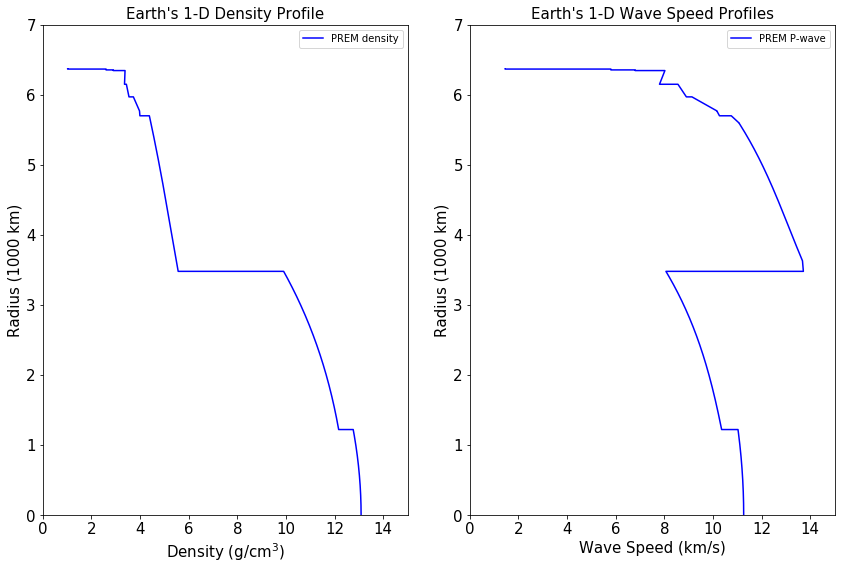

In [7]:
# Now let's make some plots of the PREM data
# example of making 2x3 grid of subplots in a 14x18 inch plot
#fig, ([ax0, ax1], [ax2,ax3], [ax4,ax5])= plt.subplots(nrows=3,ncols=2,figsize=(14,18))

sfont=15 # I like to set the size of my fonts

# we just need 2 plots
fig, (ax0, ax1)= plt.subplots(ncols=2,figsize=(12,8))
plt.subplots_adjust(wspace=0.4)

# first subplot: density vs. radius
# change units to g/cm3 and 1000 km
ax0.plot(PREM.density/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM density')
ax0.set_ylim(0.,7)
ax0.set_xlim(0,15.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Radius (1000 km)',size=sfont)
ax0.set_title('Earth\'s 1-D Density Profile',size=sfont)
ax0.tick_params(labelsize=sfont)
ax0.legend(fontsize=sfont-5)

# second subplot: p-wave, s-wave vels vs. radius
# change units to km/s and 1000 km
ax1.plot(PREM.pwavevel/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM P-wave')


## ADD the s-wave profile to this plot
## Try plotting markers instead of a line
#ax1.plot(PREM.swavevel/1.E3,PREM.radius/1.E6,'-',color='red',label='PREM S-wave')
# add symbols to the plot
#ax1.plot(PREM.swavevel/1.E3,PREM.radius/1.E6,'x',markersize=4,color='green',label='example symbols') # symbols are called 'markers' in python

ax1.set_ylim(0.,7)
ax1.set_xlim(0,15.)
ax1.set_xlabel('Wave Speed (km/s)',size=sfont)
ax1.set_ylabel('Radius (1000 km)',size=sfont)
ax1.set_title('Earth\'s 1-D Wave Speed Profiles',size=sfont)
ax1.tick_params(labelsize=sfont)
ax1.legend(fontsize=sfont-5)

# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)

# this saves a pdf file -- vector graphics are preferred
plt.savefig('PREM-plot.pdf', format='pdf', dpi=300,transparent=True)

# this is saving a png file -- raster graphics need to be very high resolution for crisp text
plt.savefig('PREM-plot.png', format='png', dpi=300,transparent=False)


## What is the pressure profile in the Earth?

To make a model planet for giant impact calculations, I need the pressure, temperature (or specific entropy), and density for each radius. PREM only gave me density vs. radius, so now I need to calculate presssure.

Use the equation for hydrostatic equilibrium:

\begin{equation}
 \frac{dP}{dr} = - \frac{GM(r)\rho(r)}{r^2}
\end{equation}

$G$ is the gravitational constant; $M(r)$ is the total mass enclosed within radius $r$, and $\rho(r)$ is the density at each radius.

We can determine $P(r)$ by starting at the surface and integrating to the center of the Earth. There are a lot of radius points in the PREM model file, so let's just take the straightforward approach of integrating the layers in the PREM model.

In [8]:
# code cell
# start at the surface and integrate via a for loop to the center of the planet

# calculate the thickness of each layer in the PREM model using the roll function
PREM_dr = np.roll(PREM.radius,-1)-PREM.radius 
PREM_dr[PREM.NR-1] = 0. # we are not using the last entry in the list because there are NR-1 layers
#print(PREM_dr)

# calculate the mass of each layer
# density x area x thickness of each layer
PREM_mass_rad = PREM.density*(4.*np.pi*PREM.radius*PREM.radius*PREM_dr) 

# Check that the total mass is the mass of the Earth
print('PREM total mass (kg)=',np.sum(PREM_mass_rad))
print('PREM total mass (Mearth)=',np.sum(PREM_mass_rad)/Mearth)

PREM_pressure = np.zeros(PREM.NR) # make array of zeros for pressure of the same length as the arrays in the PREM model
# The first entry is the middle of the planet, so start at the surface and integrate inwards
for i in range(PREM.NR-2,0,-1):
    # we indent for the code in the for loop
    PREM_pressure[i] = PREM_pressure[i+1]+G*np.sum(PREM_mass_rad[0:i-1])*PREM.density[i]*PREM_dr[i]/PREM_radius[i]/PREM_radius[i]


# can you re-write this for loop as a python in-line calculation?
# make a new variable and calculation and plot it over the original



#print(PREM_pressure)
print('Pressure at the center of the Earth (GPa):',PREM_pressure[1]/1.E9)
print('Pressure at the core-mantle-boundary (GPa):',PREM_pressure[np.where(PREM_radius == Rcmb)[0][0]]/1.E9)


PREM total mass (kg)= 5.955792638433691e+24
PREM total mass (Mearth)= 0.9972861082440876
Pressure at the center of the Earth (GPa): 354.4058065152992
Pressure at the core-mantle-boundary (GPa): 134.66382671350598


Now make your own plot of pressure vs. radius in the code cell below.


In [9]:
# Make and save your own plot of pressure vs. radius




## What is the temperature profile in the Earth?

The Earth\'s surface is about 300 K but the mantle adiabat is much warmer. 
The temperature at the intersection of the mantle adiabat with 1 bar pressure is called the mantle\'s potential 
temperature. The potential temperature is about 2000 K.<p>

The core temperature is not known and is estimated by modeling the thermal structure of the Earth. 
Here is a recent estimate from Anzellini et al., Science, 2013, where the temperature of iron alloy at the core-mantle boundary is about 4050 K:<br>
<img src="./coretemp.png" width="600" >

I used <a href="https://apps.automeris.io/wpd/">WebPlotDigitizer</a> to grab a few (P,T) points from this plot. I also use <a href="https://datathief.org/">DataThief</a>, which is a javascript program you can download.

You can try <a href="https://apps.automeris.io/wpd/">WebPlotDigitizer</a> now.

Next, read in your file or my file of (P,T) points.

In [10]:
# First let's expand our PREM class to include more variables

# make a class to hold the PREM data
class PREMclass2:
    """Class to hold PREM data and other 1-D Earth variables."""  # this is a documentation string for this class
    def __init__(self): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function
        self.NR = 0 # number of radius points
        self.radius = np.zeros(self.NR) 
        self.density = np.zeros(self.NR)   
        self.pwavevel = np.zeros(self.NR)   
        self.swavevel = np.zeros(self.NR)
        self.pressure = np.zeros(self.NR)
        self.temperature = np.zeros(self.NR)
        # not going to use all the variables in the file
        self.units = '' # I like to keep a text note in a structure about the units

# initialize an empty PREM object
PREM = PREMclass2()

# read the data into the class parameters
PREM.radius = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[0]) # radius in m
PREM.density = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[1]) # density in kg/m3
PREM.pwavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[2]) # p-wave velocity m/s
PREM.swavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[3]) # s-wave velocity m/s
PREM.NR = len(PREM.radius) # number of radius points
PREM.units = 'radius (m), density (kg/m3), pwavevel (m/s), swavevel (m/s)'
# now add the pressure calculation
PREM.pressure = PREM_pressure/1.E9 # GPa

# read in the temperature vs pressure profile from the Anzellini et al. plot
Anzellini_filename = 'coretemp.csv'
Anzellini_pressure  = np.loadtxt(Anzellini_filename,delimiter=',',skiprows=0,usecols=[0]) # GPa
Anzellini_temperature  = np.loadtxt(Anzellini_filename,delimiter=',',skiprows=0,usecols=[1]) # K

# we want to use this data with PREM but it doesn't have the same number of points
# interpolate the Anzellini profile to match the PREM profile
# the following defines a function = y(x)
interp_func = interp1d(Anzellini_pressure,Anzellini_temperature,fill_value="extrapolate") 
PREM.temperature = interp_func(PREM.pressure) # ynew = function(xnew) provides the interpolated ynew at each xnew

# what happens if you don't use the extrapolate flag in the interp1d function?

# there are som -inf values in the output from this interpolation
# you can see them by printing out the array
# how could we avoid these values?
#print(PREM.temperature)

# write the pressure vs. temperature interpolation to a file
Earth_file = open('Earth-profile.txt',"w") # open the file for writing
Earth_file.write("Pressure (GPa)       Temperature (K)\n")
for i in range(0,PREM.NR):
    Earth_file.write("{:16.8e}{:16.8e}\n".format(PREM.pressure[i], PREM.temperature[i]))
Earth_file.close() # close the file


/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


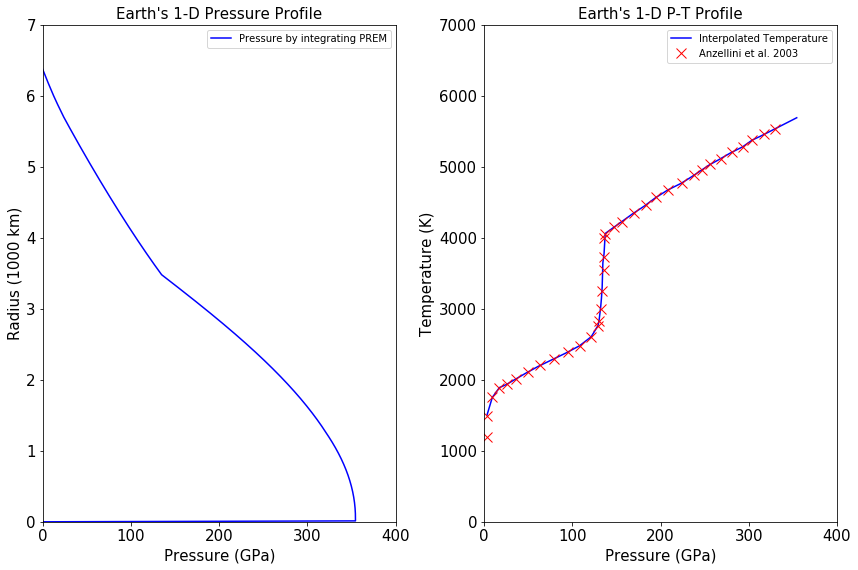

In [11]:
# make plots of pressure vs. temperature; pressure vs. radius

sfont=15 # I like to set the size of my fonts

# we just need 2 plots
fig, (ax0, ax1)= plt.subplots(ncols=2,figsize=(12,8))
plt.subplots_adjust(wspace=0.4)

# first subplot: density vs. radius
# change units to g/cm3 and 1000 km
ax0.plot(PREM.pressure,PREM.radius/1.E6,'-',color='blue',label='Pressure by integrating PREM')
ax0.set_ylim(0.,7)
ax0.set_xlim(0,400.)
ax0.set_xlabel('Pressure (GPa)',size=sfont)
ax0.set_ylabel('Radius (1000 km)',size=sfont)
ax0.set_title('Earth\'s 1-D Pressure Profile',size=sfont)
ax0.tick_params(labelsize=sfont)
ax0.legend(fontsize=sfont-5)

# second subplot: p-wave, s-wave vels vs. radius
# change units to km/s and 1000 km
ax1.plot(PREM.pressure,PREM.temperature,'-',color='blue',label='Interpolated Temperature')
ax1.plot(Anzellini_pressure,Anzellini_temperature,'x',color='red',label='Anzellini et al. 2003',markersize=10)

ax1.set_ylim(0.,7000.)
ax1.set_xlim(0,400.)
ax1.set_xlabel('Pressure (GPa)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Earth\'s 1-D P-T Profile',size=sfont)
ax1.tick_params(labelsize=sfont)
ax1.legend(fontsize=sfont-5)

# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)

# this saves a pdf file -- vector graphics are preferred
plt.savefig('Earth-PT.pdf', format='pdf', dpi=300,transparent=True)


## Make a model planet using EOS for forsterite and iron

An equation of state is a surface that describes the thermodynamic state variables of a material: pressure, temperature, density, specific internal energy, specific entropy, sound speed, specific heat capacity, etc.

You may be familiar with isotherms or isentropes (e.g., a Birch-Murnaghan curve) that describe a line across the EOS surface. 

There is a very large range of pressures and temperature generated during planetary collisions. As a result, analytic expressions cannot encompass all of the necessary phase space. So, usually, numerical simulations of planetary collisions use tabulated EOS.

In an EOS table, there are two independent variables (usually density and temperature) and several tabulated values for each (rho,T) point: Pressure, Specific Internal Energy, sound speed, etc.

You could visualize this EOS table as a stack of 2D arrays, where each layer in the stack contains a different thermodynamic variable.

I have made simple EOS tables for iron and forsterite and saved them in a standard EOS format known as 'SESAME' format. I have written code that defines and EOS class and embedded several useful functions in the class. We will use my EOS class to read in the EOS tables.

To use my EOS class, I need to include the code in this Jupyter notebook. But the code is very long and would be annoying to paste into a cell in the notebook. So, we put the code in a separate python code file and 'run' it in a cell.

In [12]:
# Run the EOS class code that is contained in an external python code file
%run extEOStable.py 
# Run the following help for the functions in the class
#help(extEOStable())

In [13]:
# Read in forsterite and iron EOS tables
# This takes a noticable minute because these are large ascii files

ForsteriteEOS = extEOStable() # make an empty EOS table object
# reads the tabulated EOS into the EOS class structure in a manner similar to filling the PREM strcture above
ForsteriteEOS.loadsesame('NEW-SESAME-FORSTERITE.TXT') 
ForsteriteEOS.loadaneos(aneosinfname='ANEOS.INPUT.FORSTERITE',aneosoutfname='ANEOS.OUTPUT.FORSTERITE')

IronEOS = extEOStable() # make an empty EOS table object
IronEOS.loadsesame('NEW-SESAME-IRON.TXT') 
IronEOS.loadaneos(aneosinfname='ANEOS.INPUT.IRON',aneosoutfname='ANEOS.OUTPUT.IRON')

print(IronEOS.units)

# I thought this would give me a comment block, but for some reason it is not.....
'''
HERE IS A BIT OF THE CLASS CODE TO SHOW YOU SOME OF THE VARIABLES IN THE STRUCTURE
class extEOStable:
    """Class for accessing EXTENDED SESAME-STYLE EOS tables output from ANEOS"""
    def __init__(self):
        self.ND  = 0 # integer; number of density points in grid
        self.NT  = 0 # integer; number of temperature points in grid
        self.rho = np.zeros(self.ND)          # g/cm3, density values
        self.T   = np.zeros(self.NT)          # K, temperature values
        self.P   = np.zeros(self.ND*self.NT)  # GPA, pressure(T,rho)
        self.U   = np.zeros(self.ND*self.NT)  # MJ/kg, sp. internal energy(T,rho)
        self.A   = np.zeros(self.ND*self.NT)  # MJ/kg, Helmholtz free energy(T,rho)
        self.S   = np.zeros(self.ND*self.NT)  # MJ/K/kg, sp. entropy(T,rho)
        self.cs  = np.zeros(self.ND*self.NT)  # cm/s, sound speed(T,rho)
        self.units = ''
'''

Done loading ANEOS files.
READING DATA FROM ANEOS OUTPUT FILE  ANEOS.OUTPUT.FORSTERITE
Done loading ANEOS files.
READING DATA FROM ANEOS OUTPUT FILE  ANEOS.OUTPUT.IRON
Units: rho g/cm3, T K, P GPa, U MJ/kg, A MJ/kg, S MJ/K/kg, cs cm/s, cv MJ/K/kg, KPA flag. 2D arrays are (NT,ND).


'\nHERE IS A BIT OF THE CLASS CODE TO SHOW YOU SOME OF THE VARIABLES IN THE STRUCTURE\nclass extEOStable:\n    """Class for accessing EXTENDED SESAME-STYLE EOS tables output from ANEOS"""\n    def __init__(self):\n        self.ND  = 0 # integer; number of density points in grid\n        self.NT  = 0 # integer; number of temperature points in grid\n        self.rho = np.zeros(self.ND)          # g/cm3, density values\n        self.T   = np.zeros(self.NT)          # K, temperature values\n        self.P   = np.zeros(self.ND*self.NT)  # GPA, pressure(T,rho)\n        self.U   = np.zeros(self.ND*self.NT)  # MJ/kg, sp. internal energy(T,rho)\n        self.A   = np.zeros(self.ND*self.NT)  # MJ/kg, Helmholtz free energy(T,rho)\n        self.S   = np.zeros(self.ND*self.NT)  # MJ/K/kg, sp. entropy(T,rho)\n        self.cs  = np.zeros(self.ND*self.NT)  # cm/s, sound speed(T,rho)\n        self.units = \'\'\n'

## What does an EOS surface look like anyway?

Here are some plots.....

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in log10
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in log10


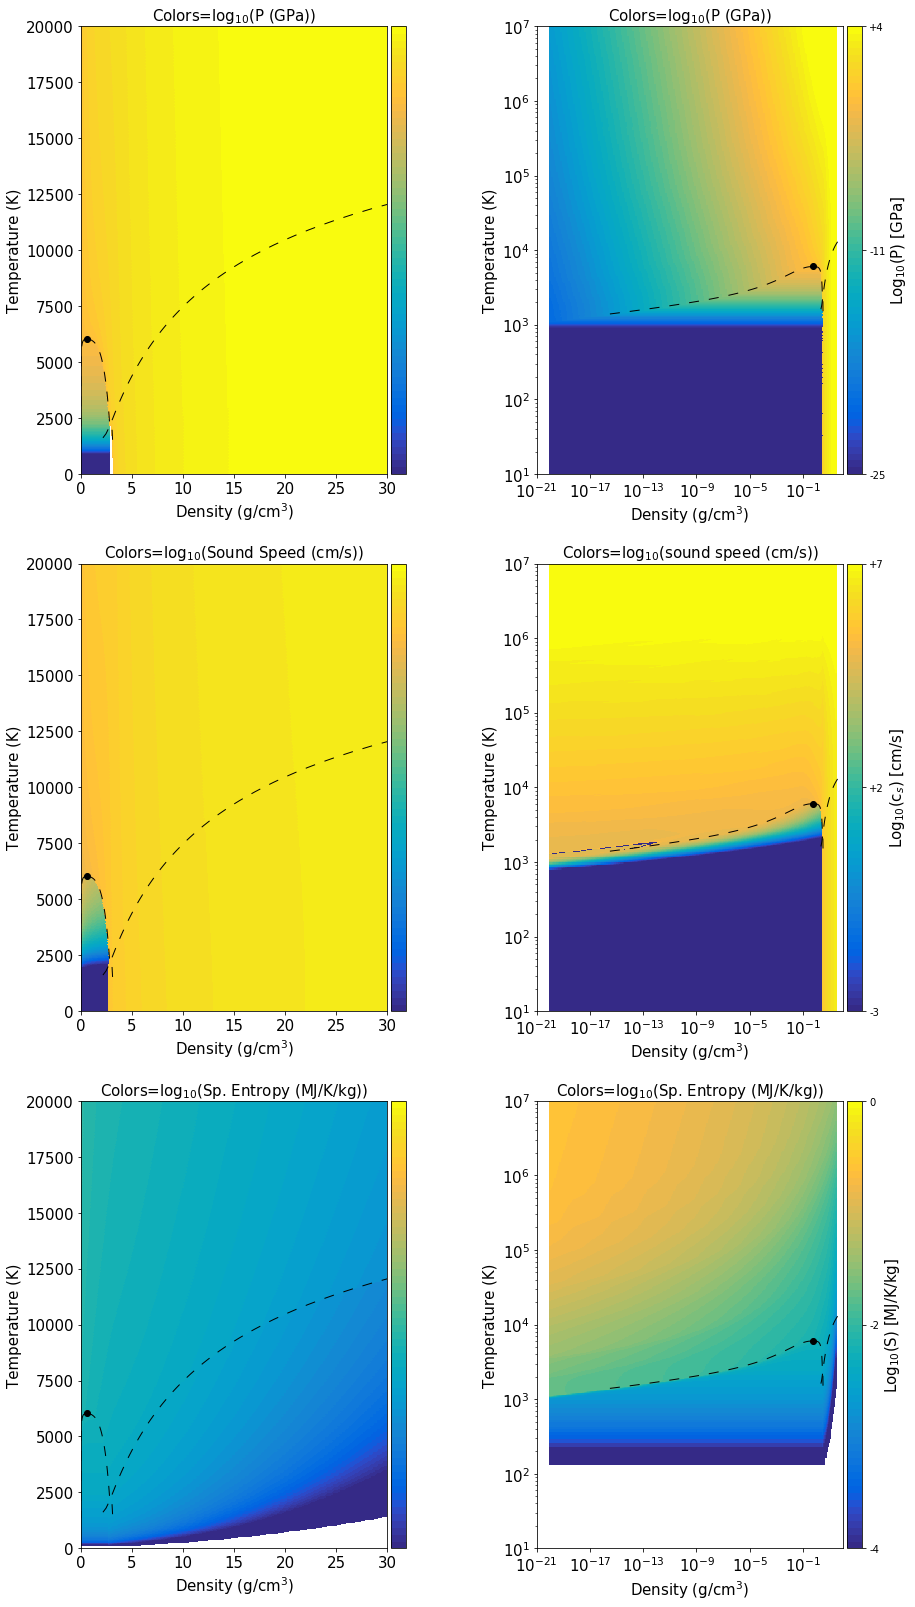

In [14]:
NewEOS = ForsteriteEOS # this does not make a copy; NewEOS points to Forsterite EOS
# look up the deepcopy command to make a copy of a class

# PLOT COLOR SHADED VALUES RHO-T TABLE
lw=1
sfont = 15
ds = (10,10)

fig, ([ax0, ax1], [ax2,ax3], [ax4,ax5])= plt.subplots(nrows=3,ncols=2,figsize=(14,28))
plt.subplots_adjust(wspace=0.4)

##================ Pressure
im1=ax0.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.P)+25)/29.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax0.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax0.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax0.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax0.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax0.set_ylim(0.,20000)
ax0.set_xlim(0,30.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Temperature (K)',size=sfont)
ax0.set_title('Colors=log$_{10}$(P (GPa))',size=sfont)
ax0.tick_params(labelsize=sfont)

divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cbar0 = fig.colorbar(im1, cax=cax0, ticks = [],orientation='vertical')

im1=ax1.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.P)+25)/29.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax1.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax1.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax1.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax1.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax1.set_ylim(10.,1.E7)
ax1.set_xlim(1.E-21,100.)
ax1.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax1.set_ylabel('Temperature (K)',size=sfont)
ax1.set_title('Colors=log$_{10}$(P (GPa))',size=sfont)
ax1.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-25','-11', '+4'])  # vertical colorbar
cbar.set_label('Log$_{10}$(P) [GPa]',size=sfont)


#================ Sound Speed
im1=ax2.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.cs)+3.)/10.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax2.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax2.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax2.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax2.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax2.set_ylim(0.,20000)
ax2.set_xlim(0,30.)
ax2.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax2.set_ylabel('Temperature (K)',size=sfont)
ax2.set_title('Colors=log$_{10}$(Sound Speed (cm/s))',size=sfont)
ax2.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')
#cbar.ax.set_yticklabels(['-3', '+2', '+7'])  # vertical colorbar


ax3.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.cs)+3.)/10.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax3.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax3.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax3.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax3.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax3.set_ylim(10.,1.E7)
ax3.set_xlim(1.E-21,100.)
ax3.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax3.set_ylabel('Temperature (K)',size=sfont)
ax3.set_title('Colors=log$_{10}$(sound speed (cm/s))',size=sfont)
ax3.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-3', '+2', '+7'])  # vertical colorbar
cbar.set_label('Log$_{10}$(c$_s$) [cm/s]',size=sfont)

#================ Sp. Entropy
im1=ax4.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.S)+4.)/4.,cmap=local_cmaps.parula,vmin=0,vmax=1,edgecolors='face')
ax4.plot(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax4.plot(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax4.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax4.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax4.set_ylim(0.,20000)
ax4.set_xlim(0,30.)
ax4.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax4.set_ylabel('Temperature (K)',size=sfont)
ax4.set_title('Colors=log$_{10}$(Sp. Entropy (MJ/K/kg))',size=sfont)
ax4.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax, ticks = [], orientation='vertical')


ax5.pcolormesh(NewEOS.rho,NewEOS.T,(np.log10(NewEOS.S)+4.)/4.,cmap=local_cmaps.parula,vmin=0,vmax=1)
ax5.loglog(NewEOS.vc.rl,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rv,NewEOS.vc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
ax5.loglog(NewEOS.vc.rl[0],NewEOS.vc.T[0],'ko')
if NewEOS.mc.NT > 0:
    ax5.plot(NewEOS.mc.rl,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)
#    ax5.plot(NewEOS.mc.rs,NewEOS.mc.T,color="black",linewidth=lw,linestyle='--',dashes=ds)

ax5.set_ylim(10.,1.E7)
ax5.set_xlim(1.E-21,100.)
ax5.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax5.set_ylabel('Temperature (K)',size=sfont)
ax5.set_title('Colors=log$_{10}$(Sp. Entropy (MJ/K/kg))',size=sfont)
ax5.tick_params(labelsize=sfont)

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
#cbar.ax.set_yticklabels(['-6', '-3.5', '-1'])  # vertical colorbar
cbar = fig.colorbar(im1, cax=cax, ticks = [0, 0.5, 1], orientation='vertical')
cbar.ax.set_yticklabels(['-4', '-2','0'])  # vertical colorbar
cbar.set_label('Log$_{10}$(S) [MJ/K/kg]',size=sfont)


# Make a 1-D Model for an Earth-like Planet

First, we will try to model Earth at today's internal temperature profile using a pure iron core and pure forsterite mantle. <p>

Inputs: central pressure, radius of the core, isentropes for the core and mantle


In [15]:
exampleplanet = 1

if exampleplanet == 1:
    Pcenter = 385.E9  # Pa
    Rcore   = 3350.E3 # m
    Score   = 0.00175 # MJ/K/kg
    Smantle = 0.0027 # MJ/K/kg
    dR = 5.E3 # m -- calculate planet layers every dR m
    Pmin = 1.E5  # Pa (1 bar)

MODEL PLANET:
Core radius =  3350000.0 3350000.0 670
CMB pressure (GPa) =  132.33586273185264
Mass (Mearth), Mcore/Mass =  0.9781641826809191 0.32811290362698864
Radius (km, Rearth) =  6455.0 1.013184743368388


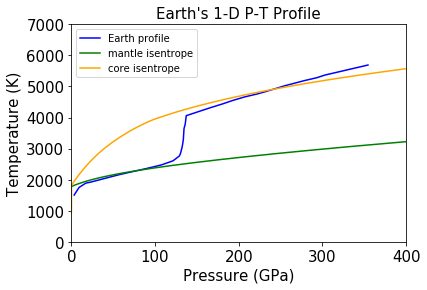

In [16]:
# calculate the structure for one planet
# make a class to hold the PREM data
class isentrope_class:
    """Class to isentrope data extracted from EOS table."""  # this is a documentation string for this class
    def __init__(self): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function
        self.ND = 0 # number of radius points
        self.density     = []   
        self.pressure    = []
        self.temperature = []
        self.soundspeed  = []
        # not going to use all the variables in the file
        self.units = '' # I like to keep a text note in a structure about the units

# first extract the isentropes for the planet from the EOS tables
mantle = isentrope_class()

# loop across all densities and extract the values for the requested isentrope
for i in range(0,ForsteriteEOS.ND):
    ind = np.where((ForsteriteEOS.S[:,i] > 0))[0]
    interpfunction = interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.P[ind,i]) # MJ/K/kg, GPa
    mantle.pressure = np.append(mantle.pressure,interpfunction(Smantle)) # GPa
    interpfunction = interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.T[ind]) # MJ/K/kg, GPa
    mantle.temperature = np.append(mantle.temperature,interpfunction(Smantle)) # GPa
mantle.density = ForsteriteEOS.rho # g/cm3

# first extract the isentropes for the planet from the EOS tables
core = isentrope_class()

# loop across all densities and extract the values for the requested isentrope
for i in range(0,IronEOS.ND):
    ind = np.where((IronEOS.S[:,i] > 0))[0]
    interpfunction = interp1d(IronEOS.S[ind,i],IronEOS.P[ind,i]) # MJ/K/kg, GPa
    core.pressure = np.append(core.pressure,interpfunction(Score)) # GPa
    interpfunction = interp1d(IronEOS.S[ind,i],IronEOS.T[ind]) # MJ/K/kg, GPa
    core.temperature = np.append(core.temperature,interpfunction(Score)) # GPa
core.density = IronEOS.rho # g/cm3


# make plots of pressure vs. temperature; pressure vs. radius

sfont=15 # I like to set the size of my fonts

# we just need 1 plot
fig = plt.figure()

plt.plot(PREM.pressure,PREM.temperature,'-',color='blue',label='Earth profile')
plt.plot(mantle.pressure,mantle.temperature,'-',color='green',label='mantle isentrope',markersize=10)
plt.plot(core.pressure,core.temperature,'-',color='orange',label='core isentrope',markersize=10)

plt.ylim(0.,7000.)
plt.xlim(0,400.)
plt.xlabel('Pressure (GPa)',size=sfont)
plt.ylabel('Temperature (K)',size=sfont)
plt.title('Earth\'s 1-D P-T Profile',size=sfont)
plt.tick_params(labelsize=sfont)
plt.legend(fontsize=sfont-5)

# USE MKS FOR THIS INTEGRAL
Pi=Pcenter
rarr = np.zeros(1)
parr = np.full(1,Pcenter) # Pa
darr = np.full(1,np.interp(Pcenter/1.E9,core.pressure,core.density)*1.E3) # kg/m3
tarr = np.full(1,np.interp(Pcenter/1.E9,core.pressure,core.temperature)) # K
menclosed = 0.
ii=1
for ii in range(1,int(Rcore/dR)+1):
    ri = ii*dR # m
    rarr = np.append(rarr,ri)
    mlayer = 4.*np.pi*rarr[ii]*rarr[ii]*dR*darr[ii-1] # kg
    if ii == 1:
        dp = G*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
    else:
        dp = G*menclosed*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
    parr = np.append(parr, parr[ii-1]-dp) # Pa
    di = np.interp(parr[ii]/1.e9,core.pressure,core.density)*1.e3 # kg/m3
    darr = np.append(darr,di) # kg/m3
    ti = np.interp(parr[ii]/1.e9,core.pressure,core.temperature) # K
    tarr = np.append(tarr,ti) # kg/m3
    menclosed = menclosed + mlayer # kg
    #print(np.mod(ii,10))
    #print(ii,mlayer,menclosed/Mearth,di,ri,dp,parr[ii]/1.e9)
    #ii=ii+1
mcore = menclosed
iendcore=ii
ii=iendcore+1
print('MODEL PLANET:')
print('Core radius = ',Rcore,rarr[ii-1],iendcore)
print('CMB pressure (GPa) = ',parr[iendcore]/1.e9)
dmantle = np.interp(parr[ii-1]/1.e9,mantle.pressure,mantle.density)*1.e3 # kg/m3
while parr[ii-1] > Pmin:
    ri = ii*dR # m
    rarr = np.append(rarr,ri)
    mlayer = 4.*np.pi*rarr[ii]*rarr[ii]*dR*darr[ii-1] # kg
    if ii == iendcore:
        dp = G*dmantle*dR/rarr[ii-1]/rarr[ii] # Pa
    else:
        dp = G*menclosed*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
    parr = np.append(parr, parr[ii-1]-dp) # Pa
    di = np.interp(parr[ii-1]/1.e9,mantle.pressure,mantle.density)*1.e3 # kg/m3
    darr = np.append(darr,di) # kg/m3
    ti = np.interp(parr[ii-1]/1.e9,mantle.pressure,mantle.temperature) # K
    tarr = np.append(tarr,ti) # kg/m3
    ii=ii+1
    menclosed = menclosed + mlayer # kg    

print('Mass (Mearth), Mcore/Mass = ',menclosed/Mearth, mcore/menclosed)
print('Radius (km, Rearth) = ',rarr[ii-1]/1.e3,rarr[ii-1]/Rearth)
#print(darr)    
#print(parr/1.E9)


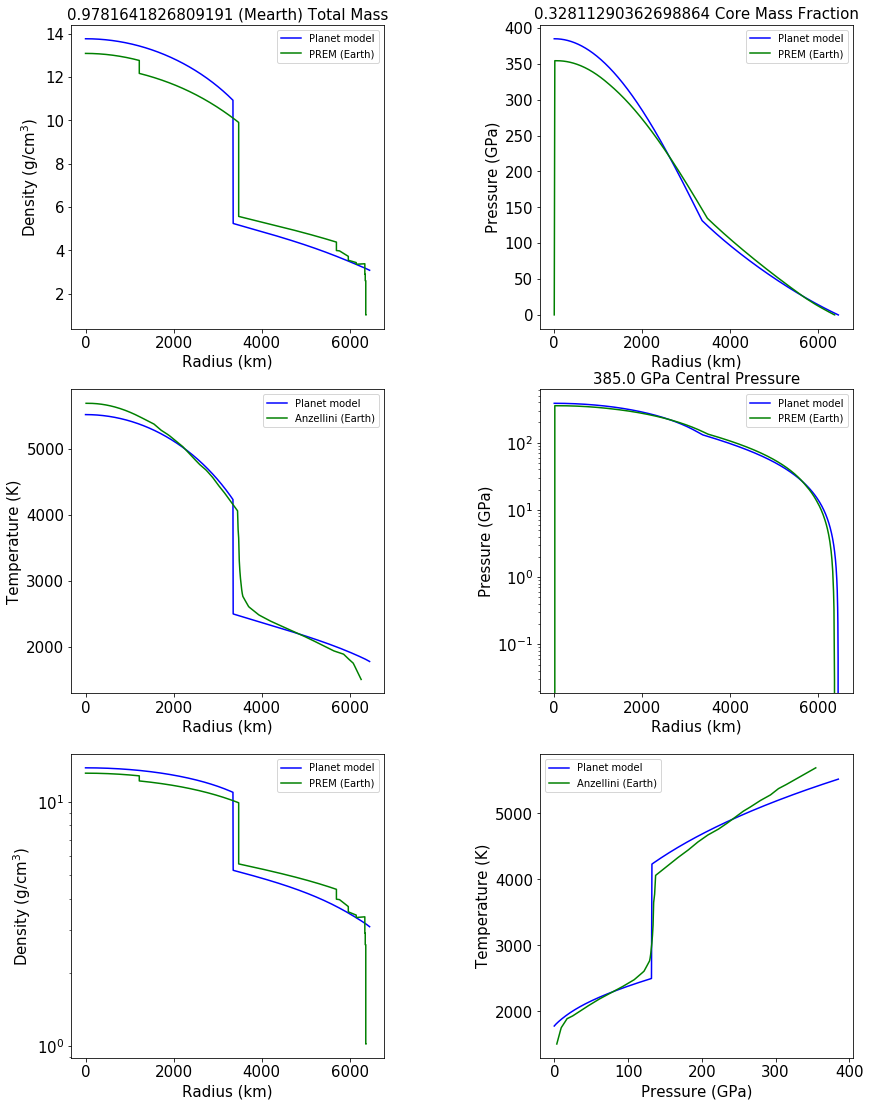

In [17]:
# Make some plots
#======================LOTS OF PLOTS============================
# Plot aneos phase boundaries with focus on the vapor curve
sfont = 15
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,19))
plt.subplots_adjust(wspace=0.5)

#------------------------------
ai=0
aj=0
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Density (g/cm$^3$)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(rarr/1.e3,darr/1.e3,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.density/1.e3,'-',color='green',label='PREM (Earth)')
axes[ai,aj].set_title(str(menclosed/Mearth)+" (Mearth) Total Mass",size=sfont)


#------------------------------
ai=0
aj=1
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(rarr/1.e3,parr/1.e9,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.pressure,'-',color='green',label='PREM (Earth)')
axes[ai,aj].set_title(str(mcore/menclosed)+" Core Mass Fraction",size=sfont)


#------------------------------
ai=1
aj=0
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(rarr/1.e3,tarr,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.temperature,'-',color='green',label='Anzellini (Earth)')

#------------------------------
ai=1
aj=1
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].semilogy(rarr/1.e3,parr/1.e9,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.pressure,'-',color='green',label='PREM (Earth)')
axes[ai,aj].set_title(str(Pcenter/1.e9)+" GPa Central Pressure",size=sfont)

#------------------------------
ai=2
aj=0
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Density (g/cm$^3$)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].semilogy(rarr/1.e3,darr/1.e3,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.density/1.e3,'-',color='green',label='PREM (Earth)')

#------------------------------
ai=2
aj=1
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(parr/1.e9,tarr,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.pressure,PREM.temperature,'-',color='green',label='Anzellini (Earth)')

# don't show a plot in lower right
#axes[2,1].axis("off")

axes[0,0].legend(fontsize=sfont-5)
axes[0,1].legend(fontsize=sfont-5)
axes[1,0].legend(fontsize=sfont-5)
axes[1,1].legend(fontsize=sfont-5)
axes[2,0].legend(fontsize=sfont-5)
axes[2,1].legend(fontsize=sfont-5)


# Mars size planet



In [18]:

exampleplanet = 2

if exampleplanet == 2:
    Pcenter = 50.E9 # Pa
    Rcore = 1780.E3 # m
    Score = 0.0018 # MJ/K/kg
    Smantle = 0.0028 # MJ/K/kg
    dR = 5.E3 # m -- calculate planet layers every dR m
    Pmin = 1.E4  # Pa (1 bar)


MODEL PLANET:
Core radius =  1780000.0 1780000.0 356
CMB pressure (GPa) =  17.310465113669455
Mass (Mearth), Mcore/Mass =  0.0936170869210304 0.35513677737352667
Radius (km, Rearth) =  3170.0 0.49756710092607126


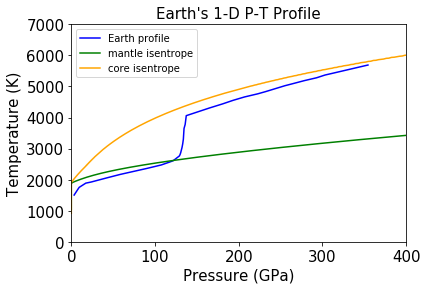

In [19]:

# first extract the isentropes for the planet from the EOS tables
mantle = isentrope_class()

# loop across all densities and extract the values for the requested isentrope
for i in range(0,ForsteriteEOS.ND):
    ind = np.where((ForsteriteEOS.S[:,i] > 0))[0]
    interpfunction = interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.P[ind,i]) # MJ/K/kg, GPa
    mantle.pressure = np.append(mantle.pressure,interpfunction(Smantle)) # GPa
    interpfunction = interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.T[ind]) # MJ/K/kg, GPa
    mantle.temperature = np.append(mantle.temperature,interpfunction(Smantle)) # GPa
mantle.density = ForsteriteEOS.rho # g/cm3

# first extract the isentropes for the planet from the EOS tables
core = isentrope_class()

# loop across all densities and extract the values for the requested isentrope
for i in range(0,IronEOS.ND):
    ind = np.where((IronEOS.S[:,i] > 0))[0]
    interpfunction = interp1d(IronEOS.S[ind,i],IronEOS.P[ind,i]) # MJ/K/kg, GPa
    core.pressure = np.append(core.pressure,interpfunction(Score)) # GPa
    interpfunction = interp1d(IronEOS.S[ind,i],IronEOS.T[ind]) # MJ/K/kg, GPa
    core.temperature = np.append(core.temperature,interpfunction(Score)) # GPa
core.density = IronEOS.rho # g/cm3


# make plots of pressure vs. temperature; pressure vs. radius

sfont=15 # I like to set the size of my fonts

# we just need 1 plot
fig = plt.figure()

plt.plot(PREM.pressure,PREM.temperature,'-',color='blue',label='Earth profile')
plt.plot(mantle.pressure,mantle.temperature,'-',color='green',label='mantle isentrope',markersize=10)
plt.plot(core.pressure,core.temperature,'-',color='orange',label='core isentrope',markersize=10)

plt.ylim(0.,7000.)
plt.xlim(0,400.)
plt.xlabel('Pressure (GPa)',size=sfont)
plt.ylabel('Temperature (K)',size=sfont)
plt.title('Earth\'s 1-D P-T Profile',size=sfont)
plt.tick_params(labelsize=sfont)
plt.legend(fontsize=sfont-5)

# USE MKS FOR THIS INTEGRAL
Pi=Pcenter
rarr = np.zeros(1)
parr = np.full(1,Pcenter) # Pa
darr = np.full(1,np.interp(Pcenter/1.E9,core.pressure,core.density)*1.E3) # kg/m3
tarr = np.full(1,np.interp(Pcenter/1.E9,core.pressure,core.temperature)) # K
menclosed = 0.
ii=1
for ii in range(1,int(Rcore/dR)+1):
    ri = ii*dR # m
    rarr = np.append(rarr,ri)
    mlayer = 4.*np.pi*rarr[ii]*rarr[ii]*dR*darr[ii-1] # kg
    if ii == 1:
        dp = G*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
    else:
        dp = G*menclosed*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
    parr = np.append(parr, parr[ii-1]-dp) # Pa
    di = np.interp(parr[ii]/1.e9,core.pressure,core.density)*1.e3 # kg/m3
    darr = np.append(darr,di) # kg/m3
    ti = np.interp(parr[ii]/1.e9,core.pressure,core.temperature) # K
    tarr = np.append(tarr,ti) # kg/m3
    menclosed = menclosed + mlayer # kg
    #print(np.mod(ii,10))
    #print(ii,mlayer,menclosed/Mearth,di,ri,dp,parr[ii]/1.e9)
    #ii=ii+1
mcore = menclosed
iendcore=ii
ii=iendcore+1
print('MODEL PLANET:')
print('Core radius = ',Rcore,rarr[ii-1],iendcore)
print('CMB pressure (GPa) = ',parr[iendcore]/1.e9)
dmantle = np.interp(parr[ii-1]/1.e9,mantle.pressure,mantle.density)*1.e3 # kg/m3
while parr[ii-1] > Pmin:
    ri = ii*dR # m
    rarr = np.append(rarr,ri)
    mlayer = 4.*np.pi*rarr[ii]*rarr[ii]*dR*darr[ii-1] # kg
    if ii == iendcore:
        dp = G*dmantle*dR/rarr[ii-1]/rarr[ii] # Pa
    else:
        dp = G*menclosed*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
    parr = np.append(parr, parr[ii-1]-dp) # Pa
    di = np.interp(parr[ii-1]/1.e9,mantle.pressure,mantle.density)*1.e3 # kg/m3
    darr = np.append(darr,di) # kg/m3
    ti = np.interp(parr[ii-1]/1.e9,mantle.pressure,mantle.temperature) # K
    tarr = np.append(tarr,ti) # kg/m3
    ii=ii+1
    menclosed = menclosed + mlayer # kg    

print('Mass (Mearth), Mcore/Mass = ',menclosed/Mearth, mcore/menclosed)
print('Radius (km, Rearth) = ',rarr[ii-1]/1.e3,rarr[ii-1]/Rearth)


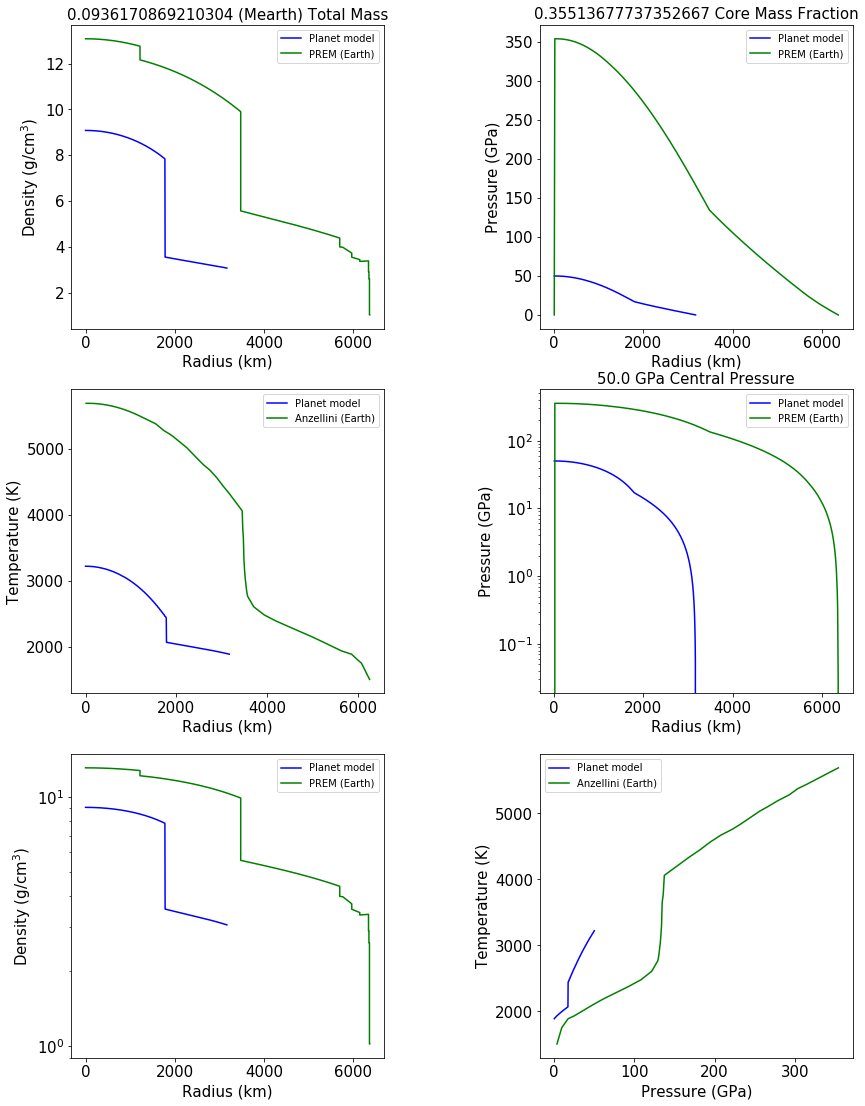

In [20]:
# Make some plots
#======================LOTS OF PLOTS============================
# Plot aneos phase boundaries with focus on the vapor curve
sfont = 15
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,19))
plt.subplots_adjust(wspace=0.5)

#------------------------------
ai=0
aj=0
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Density (g/cm$^3$)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(rarr/1.e3,darr/1.e3,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.density/1.e3,'-',color='green',label='PREM (Earth)')
axes[ai,aj].set_title(str(menclosed/Mearth)+" (Mearth) Total Mass",size=sfont)


#------------------------------
ai=0
aj=1
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(rarr/1.e3,parr/1.e9,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.pressure,'-',color='green',label='PREM (Earth)')
axes[ai,aj].set_title(str(mcore/menclosed)+" Core Mass Fraction",size=sfont)


#------------------------------
ai=1
aj=0
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(rarr/1.e3,tarr,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.temperature,'-',color='green',label='Anzellini (Earth)')

#------------------------------
ai=1
aj=1
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].semilogy(rarr/1.e3,parr/1.e9,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.pressure,'-',color='green',label='PREM (Earth)')
axes[ai,aj].set_title(str(Pcenter/1.e9)+" GPa Central Pressure",size=sfont)

#------------------------------
ai=2
aj=0
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Density (g/cm$^3$)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].semilogy(rarr/1.e3,darr/1.e3,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.density/1.e3,'-',color='green',label='PREM (Earth)')

#------------------------------
ai=2
aj=1
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(parr/1.e9,tarr,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.pressure,PREM.temperature,'-',color='green',label='Anzellini (Earth)')

# don't show a plot in lower right
#axes[2,1].axis("off")

axes[0,0].legend(fontsize=sfont-5)
axes[0,1].legend(fontsize=sfont-5)
axes[1,0].legend(fontsize=sfont-5)
axes[1,1].legend(fontsize=sfont-5)
axes[2,0].legend(fontsize=sfont-5)
axes[2,1].legend(fontsize=sfont-5)


## Hot Earth-like planet



In [21]:
exampleplanet = 3

if exampleplanet == 3:
    Pcenter = 385.E9  # Pa
    Rcore   = 3350.E3 # m
    Score   = 0.0023 # MJ/K/kg
    Smantle = 0.005 # MJ/K/kg
    dR = 5.E3 # m -- calculate planet layers every dR m
    Pmin = 1.E5  # Pa (1 bar)

MODEL PLANET:
Core radius =  3350000.0 3350000.0 670
CMB pressure (GPa) =  155.10639727008237
Mass (Mearth), Mcore/Mass =  1.2772353080116352 0.23974375176704152
Radius (km, Rearth) =  7520.0 1.180348453931879


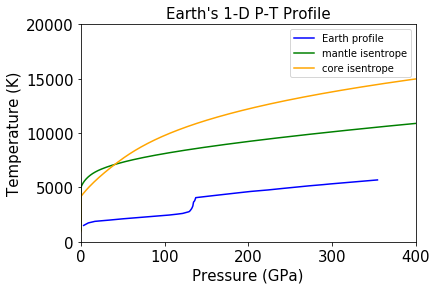

In [22]:

# first extract the isentropes for the planet from the EOS tables
mantle = isentrope_class()

# loop across all densities and extract the values for the requested isentrope
for i in range(0,ForsteriteEOS.ND):
    ind = np.where((ForsteriteEOS.S[:,i] > 0))[0]
    interpfunction = interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.P[ind,i]) # MJ/K/kg, GPa
    mantle.pressure = np.append(mantle.pressure,interpfunction(Smantle)) # GPa
    interpfunction = interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.T[ind]) # MJ/K/kg, GPa
    mantle.temperature = np.append(mantle.temperature,interpfunction(Smantle)) # GPa
mantle.density = ForsteriteEOS.rho # g/cm3

# first extract the isentropes for the planet from the EOS tables
core = isentrope_class()

# loop across all densities and extract the values for the requested isentrope
for i in range(0,IronEOS.ND):
    ind = np.where((IronEOS.S[:,i] > 0))[0]
    interpfunction = interp1d(IronEOS.S[ind,i],IronEOS.P[ind,i]) # MJ/K/kg, GPa
    core.pressure = np.append(core.pressure,interpfunction(Score)) # GPa
    interpfunction = interp1d(IronEOS.S[ind,i],IronEOS.T[ind]) # MJ/K/kg, GPa
    core.temperature = np.append(core.temperature,interpfunction(Score)) # GPa
core.density = IronEOS.rho # g/cm3


# make plots of pressure vs. temperature; pressure vs. radius

sfont=15 # I like to set the size of my fonts

# we just need 1 plot
fig = plt.figure()

plt.plot(PREM.pressure,PREM.temperature,'-',color='blue',label='Earth profile')
plt.plot(mantle.pressure,mantle.temperature,'-',color='green',label='mantle isentrope',markersize=10)
plt.plot(core.pressure,core.temperature,'-',color='orange',label='core isentrope',markersize=10)

plt.ylim(0.,20000.)
plt.xlim(0,400.)
plt.xlabel('Pressure (GPa)',size=sfont)
plt.ylabel('Temperature (K)',size=sfont)
plt.title('Earth\'s 1-D P-T Profile',size=sfont)
plt.tick_params(labelsize=sfont)
plt.legend(fontsize=sfont-5)

# USE MKS FOR THIS INTEGRAL
Pi=Pcenter
rarr = np.zeros(1)
parr = np.full(1,Pcenter) # Pa
darr = np.full(1,np.interp(Pcenter/1.E9,core.pressure,core.density)*1.E3) # kg/m3
tarr = np.full(1,np.interp(Pcenter/1.E9,core.pressure,core.temperature)) # K
menclosed = 0.
ii=1
for ii in range(1,int(Rcore/dR)+1):
    ri = ii*dR # m
    rarr = np.append(rarr,ri)
    mlayer = 4.*np.pi*rarr[ii]*rarr[ii]*dR*darr[ii-1] # kg
    if ii == 1:
        dp = G*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
    else:
        dp = G*menclosed*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
    parr = np.append(parr, parr[ii-1]-dp) # Pa
    di = np.interp(parr[ii]/1.e9,core.pressure,core.density)*1.e3 # kg/m3
    darr = np.append(darr,di) # kg/m3
    ti = np.interp(parr[ii]/1.e9,core.pressure,core.temperature) # K
    tarr = np.append(tarr,ti) # kg/m3
    menclosed = menclosed + mlayer # kg
    #print(np.mod(ii,10))
    #print(ii,mlayer,menclosed/Mearth,di,ri,dp,parr[ii]/1.e9)
    #ii=ii+1
mcore = menclosed
iendcore=ii
ii=iendcore+1
print('MODEL PLANET:')
print('Core radius = ',Rcore,rarr[ii-1],iendcore)
print('CMB pressure (GPa) = ',parr[iendcore]/1.e9)
dmantle = np.interp(parr[ii-1]/1.e9,mantle.pressure,mantle.density)*1.e3 # kg/m3
while parr[ii-1] > Pmin:
    ri = ii*dR # m
    rarr = np.append(rarr,ri)
    mlayer = 4.*np.pi*rarr[ii]*rarr[ii]*dR*darr[ii-1] # kg
    if ii == iendcore:
        dp = G*dmantle*dR/rarr[ii-1]/rarr[ii] # Pa
    else:
        dp = G*menclosed*darr[ii-1]*dR/rarr[ii]/rarr[ii] # Pa
    parr = np.append(parr, parr[ii-1]-dp) # Pa
    di = np.interp(parr[ii-1]/1.e9,mantle.pressure,mantle.density)*1.e3 # kg/m3
    darr = np.append(darr,di) # kg/m3
    ti = np.interp(parr[ii-1]/1.e9,mantle.pressure,mantle.temperature) # K
    tarr = np.append(tarr,ti) # kg/m3
    ii=ii+1
    menclosed = menclosed + mlayer # kg    

print('Mass (Mearth), Mcore/Mass = ',menclosed/Mearth, mcore/menclosed)
print('Radius (km, Rearth) = ',rarr[ii-1]/1.e3,rarr[ii-1]/Rearth)


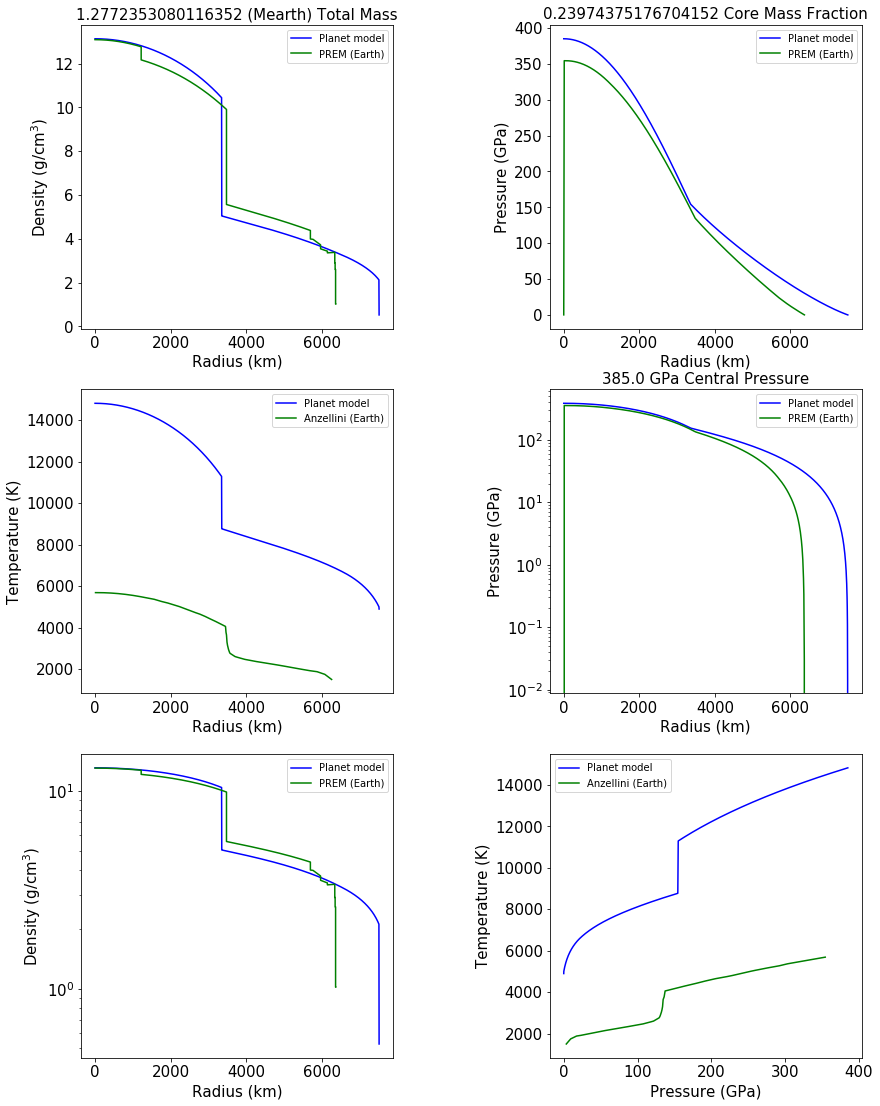

In [23]:
# Make some plots
#======================LOTS OF PLOTS============================
# Plot aneos phase boundaries with focus on the vapor curve
sfont = 15
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,19))
plt.subplots_adjust(wspace=0.5)

#------------------------------
ai=0
aj=0
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Density (g/cm$^3$)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(rarr/1.e3,darr/1.e3,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.density/1.e3,'-',color='green',label='PREM (Earth)')
axes[ai,aj].set_title(str(menclosed/Mearth)+" (Mearth) Total Mass",size=sfont)


#------------------------------
ai=0
aj=1
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(rarr/1.e3,parr/1.e9,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.pressure,'-',color='green',label='PREM (Earth)')
axes[ai,aj].set_title(str(mcore/menclosed)+" Core Mass Fraction",size=sfont)


#------------------------------
ai=1
aj=0
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(rarr/1.e3,tarr,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.temperature,'-',color='green',label='Anzellini (Earth)')

#------------------------------
ai=1
aj=1
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].semilogy(rarr/1.e3,parr/1.e9,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.pressure,'-',color='green',label='PREM (Earth)')
axes[ai,aj].set_title(str(Pcenter/1.e9)+" GPa Central Pressure",size=sfont)

#------------------------------
ai=2
aj=0
axes[ai,aj].set_xlabel('Radius (km)',size=sfont)
axes[ai,aj].set_ylabel('Density (g/cm$^3$)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].semilogy(rarr/1.e3,darr/1.e3,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.radius/1.e3,PREM.density/1.e3,'-',color='green',label='PREM (Earth)')

#------------------------------
ai=2
aj=1
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)

axes[ai,aj].plot(parr/1.e9,tarr,'-',color='blue',label='Planet model')
axes[ai,aj].plot(PREM.pressure,PREM.temperature,'-',color='green',label='Anzellini (Earth)')

# don't show a plot in lower right
#axes[2,1].axis("off")

axes[0,0].legend(fontsize=sfont-5)
axes[0,1].legend(fontsize=sfont-5)
axes[1,0].legend(fontsize=sfont-5)
axes[1,1].legend(fontsize=sfont-5)
axes[2,0].legend(fontsize=sfont-5)
axes[2,1].legend(fontsize=sfont-5)
